In [101]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
%matplotlib inline
import xgboost as xgb
from sklearn.tree import export_graphviz
import graphviz,re

In [102]:
## From fastai library
def draw_tree(t, df, size=10, ratio=0.6, precision=1):
    """ Draws a representation of a random forest in IPython.

    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

 Let produce some fake data first.

In [103]:
np.random.randn(1)

array([-0.11781303])

In [104]:
n=365*11 # Pretend we have 4 years of time series

In [105]:
linear,trend,seasonality,noise=[],[],[],[]
for i in range(n):
    linear.append(1)
    trend.append(i*0.001)
    seasonality.append(1.2*math.sin(math.pi*i*2/365))  ## 1 year as a cycle
   
    
linear=np.array(linear)
trend=np.array(trend)
seasonality=np.array(seasonality)
noise = (np.random.randn(n)).reshape(-1)*0.3

Text(0.5,1,'noise')

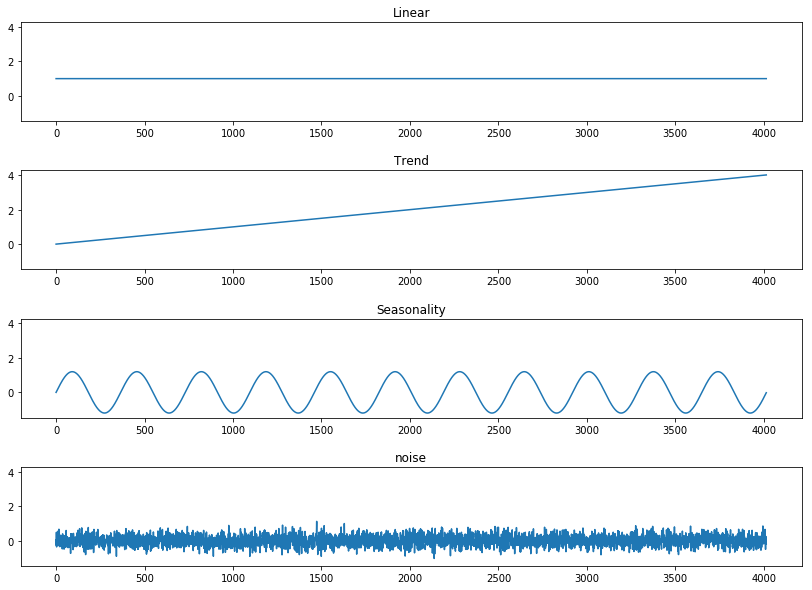

In [106]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharey=True,figsize=(14,10))
f.subplots_adjust(hspace=0.5)
ax1.plot(np.arange(n),linear)
ax2.plot(np.arange(n),trend)
ax3.plot(np.arange(n),seasonality)
ax4.plot(np.arange(n),noise)
ax1.set_title('Linear')
ax2.set_title('Trend')
ax3.set_title('Seasonality')
ax4.set_title('noise')

Combining all three become our fake time series

In [107]:
(linear+trend+seasonality+noise).shape

(4015,)

In [108]:
y=linear+trend+seasonality+noise
x=np.arange(n)

In [109]:
y=y.reshape(-1,1)
x=x.reshape(-1,1)

Text(0.5,1,'Fake Data')

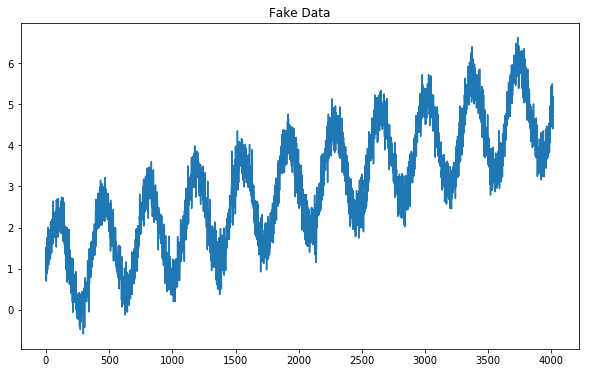

In [110]:
plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.title('Fake Data')

## Prepare Train/Test Data by reserving the last year data

In [111]:
n_valid = 365*4

In [112]:
idx = np.random.random_integers(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  """Entry point for launching an IPython kernel.


In [113]:
idx =np.arange(n)

In [114]:
train_idx = idx[:-n_valid]
valid_idx = idx[-n_valid:]

In [115]:
## Make sure you shuffle the data after you split the train/valid set
np.random.shuffle(train_idx)
np.random.shuffle(valid_idx)

In [116]:
x_train = x[train_idx]
x_valid = x[valid_idx]
y_train = y[train_idx]
y_valid = y[valid_idx]

In [117]:
x_train.shape,y_train.shape,x_valid.shape,y_valid.shape

((2555, 1), (2555, 1), (1460, 1), (1460, 1))

In [118]:
x_train=pd.DataFrame(x_train,columns=['Date'])
x_valid=pd.DataFrame(x_valid,columns=['Date'])

## No Feature Engineering

### Model 1 Random Forest 

In [119]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [120]:
m1 = RandomForestRegressor(n_estimators=100,max_depth=20)
m1.fit(x_train,y_train)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [121]:
m1_predict_valid = m1.predict(x_valid).reshape(-1,1)
m1_predict_train = m1.predict(x_train).reshape(-1,1)

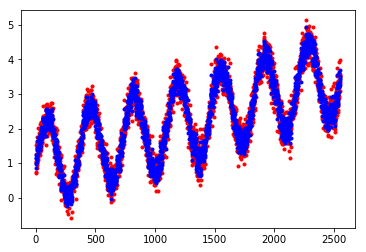

In [122]:
plt.plot(train_idx,y_train,'r.')
plt.plot(train_idx, m1_predict_train,'b.')

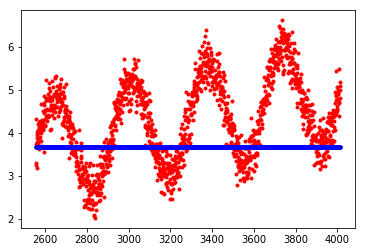

In [123]:
plt.plot(valid_idx,y_valid,'r.')
plt.plot(valid_idx, m1_predict_valid,'b.')

To explain this, it will be easier to start with 1 tree, as RandomForest is basically average of mutiples tree.

In [124]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

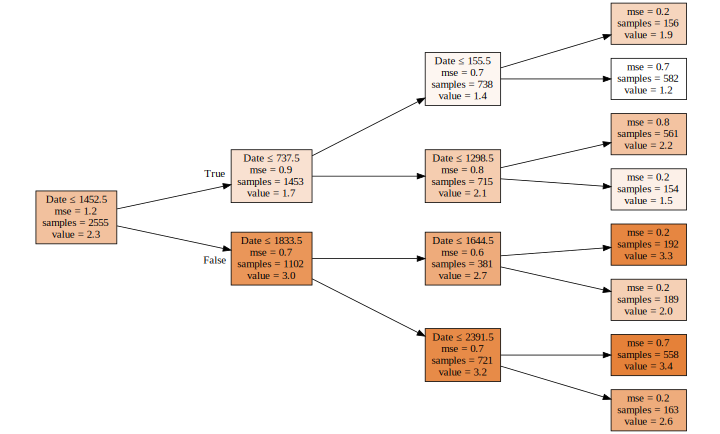

In [125]:
draw_tree(tree,x_train)

Max_depth is set to 2 only for showing the tree, otherwise it will be too big. So you can get some idea what this Regressor is actually doing. Each time it set a linear classifier to seperate data into 2 groups and average the values. Therefore, there are no "Regression" happening, thus it can only average number. If you want to do some extrapolation (time series trend), Tree cannot deal with it naturally.

### Model 2 XGBoost

How about Boosted Tree? 

In [126]:
from xgboost import XGBRegressor

In [127]:
m2 = XGBRegressor(max_depth=5)
m2.fit(x_train,y_train)
m2_predict = m2.predict(x_valid).reshape(-1,1)

In [128]:
m2.fit(x_train,y_train)
m2_predict = m2.predict(x_valid).reshape(-1,1)
m2_predict_train = m2.predict(x_train).reshape(-1,1)

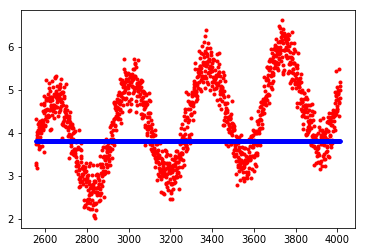

In [129]:
plt.plot(x_valid,y_valid,'r.')
plt.plot(x_valid, m2_predict,'b.')

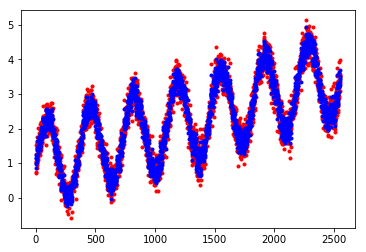

In [130]:
plt.plot(train_idx,y_train,'r.')
plt.plot(train_idx, m1_predict_train,'b.')

## Add Date Features

In [131]:
## From fastai library, https://github.com/fastai/fastai
import re

def add_datepart(df, fldname, drop=True):

    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [132]:
n

4015

In [133]:
train = pd.DataFrame(pd.date_range('2012-01-01',periods=n, freq='d'),columns=['Date'])
add_datepart(train,'Date')

In [134]:
x_train = train.loc[train_idx]
x_valid = train.loc[valid_idx]

In [135]:
x_train.tail()

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
17,2012,1,3,18,2,18,False,False,False,False,False,False,1326844800
2497,2018,11,44,2,4,306,False,False,False,False,False,False,1541116800
133,2012,5,19,13,6,134,False,False,False,False,False,False,1336867200
552,2013,7,27,6,5,187,False,False,False,False,False,False,1373068800
1962,2017,5,20,16,1,136,False,False,False,False,False,False,1494892800


In [136]:
x_valid.head()

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
3312,2021,1,4,25,0,25,False,False,False,False,False,False,1611532800
3167,2020,9,36,2,2,246,False,False,False,False,False,False,1599004800
3831,2022,6,26,28,1,179,False,False,False,False,False,False,1656374400
2748,2019,7,28,11,3,192,False,False,False,False,False,False,1562803200
3714,2022,3,9,3,3,62,False,False,False,False,False,False,1646265600


### Model 1 Random Forest 

In [137]:
cols = x_train.columns

In [138]:
m1.fit(x_train[cols],y_train)
m1_predict = m1.predict(x_valid[cols]).reshape(-1,1)
m1_predict_train = m1.predict(x_train[cols]).reshape(-1,1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


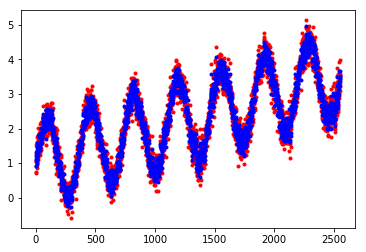

In [139]:
plt.plot(train_idx,y_train,'r.')
plt.plot(train_idx, m1_predict_train,'b.')

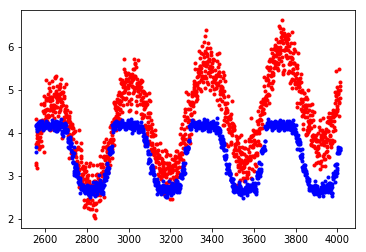

In [140]:
plt.plot(valid_idx,y_valid,'r.')
plt.plot(valid_idx, m1_predict,'b.')

In [141]:
cols

Index(['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype='object')

Feature ranking:
1. feature 12 (0.507286)
2. feature 5 (0.338652)
3. feature 2 (0.104016)
4. feature 3 (0.018603)
5. feature 4 (0.016185)
6. feature 1 (0.009235)
7. feature 0 (0.004792)
8. feature 6 (0.000508)
9. feature 7 (0.000430)
10. feature 9 (0.000202)
11. feature 8 (0.000069)
12. feature 11 (0.000013)
13. feature 10 (0.000010)


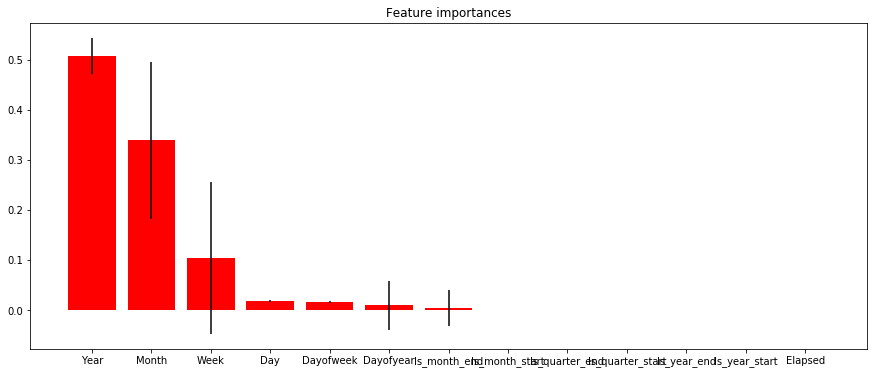

In [142]:
importances = m1.feature_importances_
std = np.std([tree.feature_importances_ for tree in m1.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(cols)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,6))
plt.title("Feature importances")
plt.bar(range(len(cols)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(cols)), cols)
# plt.xlim([-1, x_train.shape[1]])
plt.show()

In [ ]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(x_train,y_train)
draw_tree(tree,x_train)